## jsonメモ

## 本番向け

In [1]:
import os
import sys
import time


from pixivpy3 import *


from src.route.service.module.utils import const

p = const.Path()

save_dir = os.path.join(p.archive(), "pixiv")

opt = const.Option()
members = opt.holo_wiki_members()
print(members)

['ときのそら', 'ロボ子さん', 'さくらみこ', '星街すいせい', 'AZki', '夜空メル', 'アキ・ローゼンタール', '赤井はあと', '白上フブキ', '夏色まつり', '湊あくあ', '紫咲シオン', '百鬼あやめ', '癒月ちょこ', '大空スバル', '大神ミオ', '猫又おかゆ', '戌神ころね', '兎田ぺこら', '不知火フレア', '白銀ノエル', '宝鐘マリン', '天音かなた', '角巻わため', '常闇トワ', '姫森ルーナ', '雪花ラミィ', '桃鈴ねね', '獅白ぼたん', '尾丸ポルカ', 'ラプラス・ダークネス', '高嶺ルイ', '博衣こより', '沙花叉クロヱ', '風真いろは', 'Ayunda Risu', 'Moona Hoshinova', 'Airani Iofifteen', 'Kureiji Ollie', 'Anya Melfissa', 'Pavolia Reine', 'Vestia Zeta', 'Kaela Kovalskia', 'Kobo Kanaeru', 'Mori Calliope', 'Takanashi Kiara', "Ninomae Ina'nis", 'Gawr Gura', 'Watson Amelia', 'IRyS', 'Ceres Fauna', 'Ouro Kronii', 'Nanashi Mumei', 'Hakos Baelz', 'Shiori Novella', 'Koseki Bijou', 'Nerissa Ravencroft', 'Fuwawa Abyssgard', '火威青', '音乃瀬奏', '一条莉々華', '儒烏風亭らでん', '轟はじめ', 'Elizabeth Rose Bloodflame', 'Gigi Murin', 'Cecilia Immergreen', 'Raora Panthera', '友人A', '春先のどか']


In [2]:
def get_api():
    """
    検索に使用する
    """
    api = AppPixivAPI()
    api.auth(refresh_token="kBn2GtDM4l3JJiVXLJBsa0BOl0s_p2JUU9wQlTHalqk")
    return api

def search_illusts(query:str):
    """
    pixivで指定したキーワードで全データ検索
    """
    # 検索条件
    illusts = []
    keyword = f"{query} 000user"
    
    # 初回検索（最初のページを取得）
    json_result = api.search_illust(word=keyword)
    time.sleep(1)
    illusts.extend(json_result.illusts)
    
    # 検索結果が無くなるまで検索
    while json_result:
        illusts.extend(json_result.illusts)
        
        # 次のページが存在する場合は次のページを取得
        if 'next_url' in json_result:
            next_qs = api.parse_qs(json_result.next_url)
            if next_qs is None:
                return illusts
            json_result = api.search_illust(**next_qs)
            time.sleep(1)
        else:
            return illusts

def detail_user(id:str):
    """
    ユーザーの詳細を取得
    """
    if type(id) == int:
        id = str(id)

    return api.user_detail(id)

## テスト

In [17]:
import sqlite3
from src.route.service.module.utils import const
from tqdm.notebook import tqdm

p = const.Path()
dbname = p.db_pixiv()
print(dbname)

api = get_api()

/Users/sakura0moti/Documents/git/sharemoti3/api/src/database/pixiv.db


NameError: name 'get_api' is not defined

In [4]:
# テーブル作成関数
def execute_query_only(query:str):
    con = sqlite3.connect(dbname)
    cur = con.cursor()
    cur.execute(query)
    
    con.commit()
    con.close()

#テーブル作成クエリ
illust_query = """CREATE TABLE IF NOT EXISTS illust(
                        id INTEGER PRIMARY KEY,
                        title STRING,
                        type STRING,
                        caption STRING,
                        user_id INTEGER,
                        create_date STRING,
                        page_count INTEGER,
                        width INTEGER,
                        height INTEGER,
                        sanity_level INTEGER,
                        total_view INTEGER,
                        total_bookmarks INTEGER,
                        illust_ai_type INTEGER
                    )
                """

hashtag_query = """CREATE TABLE IF NOT EXISTS hashtag(
                        id INTEGER NOT NULL,
                        name STRING NOT NULL,
                        translated_name STRING
                    )
                """

user_query = """CREATE TABLE IF NOT EXISTS user(
                    id INTEGER PRIMARY KEY,
                    name STRING,
                    account STRING,
                    profile_image_url_square_medium STRING,
                    profile_image_url_medium STRING,
                    profile_image_url_large STRING
                )
             """

image_query = """CREATE TABLE IF NOT EXISTS image(
                    id INTEGER NOT NULL,
                    line INTEGER NOT NULL,
                    image_url_square_medium STRING,
                    image_url_medium STRING,
                    image_url_large STRING,
                    original_image_url STRING
                )
              """

querys = [
    illust_query, hashtag_query, user_query, image_query
]
for query in querys:
    execute_query_only(query)

In [5]:
#レコード追加関数
def execute(query:str, args:dict):
    con = sqlite3.connect(dbname)
    cur = con.cursor()
    cur.execute(query, args)
    
    con.commit()
    con.close()

def insert_illust_query():
    return """
            INSERT INTO illust
            SELECT * FROM
            (
                SELECT
                    :id,
                    :title,
                    :type,
                    :caption,
                    :user_id,
                    :create_date,
                    :page_count,
                    :width,
                    :height,
                    :sanity_level,
                    :total_view,
                    :total_bookmarks,
                    :illust_ai_type
                WHERE NOT EXISTS
                (
                    SELECT 1 FROM illust WHERE
                    id = :id
                )
            )
            """

def args_illust(illust):
    return {
        'id':illust.id,
        'title':illust.title,
        'type':illust.type,
        'caption':illust.caption,
        'user_id':illust.user.id,
        'create_date':illust.create_date,
        'page_count':illust.page_count,
        'width':illust.width,
        'height':illust.height,
        'sanity_level':illust.sanity_level,
        'total_view':illust.total_view,
        'total_bookmarks':illust.total_bookmarks,
        'illust_ai_type':illust.illust_ai_type
    }

def insert_hashtag_query():
    return """
        INSERT INTO hashtag
            SELECT * FROM
            (
                SELECT
                    :id,
                    :name,
                    :translated_name
                WHERE NOT EXISTS
                (
                    SELECT 1 FROM hashtag
                    WHERE
                        id = :id
                        and name =:name
                )
            )
    """

def args_list_hashtag(illust):
    args_list = []
    for tag in illust.tags:
        args_list.append(
            {
                'id' : illust.id,
                'name' : tag.name,
                'translated_name' :tag.translated_name
            }
        )
    return args_list

def insert_user_query():
    return """
        INSERT INTO user
            SELECT * FROM
            (
                SELECT
                    :id,
                    :name,
                    :account,
                    :profile_image_url_square_medium,
                    :profile_image_url_medium,
                    :profile_image_url_large
                WHERE NOT EXISTS
                (
                    SELECT 1 FROM user
                    WHERE id = :id
                )
            )
    """

def args_user(illust):
    return {
        "id":illust.user.id,
        "name":illust.user.name,
        "account":illust.user.account,
        "profile_image_url_square_medium":illust.user.profile_image_urls.get('square_medium'),
        "profile_image_url_medium":illust.user.profile_image_urls.get('medium'),
        "profile_image_url_large":illust.user.profile_image_urls.get('large')
    }

def insert_image_query():
    return """
        INSERT INTO image
            SELECT * FROM
            (
                SELECT
                    :id,
                    :line,
                    :image_url_square_medium,
                    :image_url_medium,
                    :image_url_large,
                    :original_image_url
                WHERE NOT EXISTS
                (
                    SELECT 1 FROM image
                    WHERE id = :id and line = :line
                )
            )
    """

def args_list_image(illust):
    args_list = []
    urls = [page.image_urls for page in illust.meta_pages]
    if len(urls) == 0:
        urls.append(illust.image_urls)
        
    for index, image_url in enumerate(urls):
        args_list.append({
            "id":illust.id,
            "line":index,
            "image_url_square_medium":image_url.square_medium,
            "image_url_medium":image_url.medium,
            "image_url_large":image_url.large,
            "original_image_url":image_url.original
        })
    return args_list

In [6]:
#レコード更新
def update_illust_query():
    return """
        UPDATE illust 
        SET 
            title = :title,
            type = :type,
            caption = :caption,
            user_id = :user_id,
            create_date = :create_date,
            page_count = :page_count,
            width = :width,
            height = :height,
            sanity_level = :sanity_level,
            total_view = :total_view,
            total_bookmarks = :total_bookmarks,
            illust_ai_type = :illust_ai_type
        WHERE id = :id
    """

def update_user_query():
    return """
        UPDATE user
        SET
            name = :name,
            account = :account,
            profile_image_url_square_medium = :profile_image_url_square_medium,
            profile_image_url_medium = :profile_image_url_medium,
            profile_image_url_large = :profile_image_url_large
        WHERE id = :id
    """

In [7]:
def execute_illust(illust):
    query = insert_illust_query()
    args = args_illust(illust)
    execute(query, args)

    query = update_illust_query()
    execute(query, args)


def execute_hashtag(illust):
    query = insert_hashtag_query()
    args_list = args_list_hashtag(illust)
    for args in args_list:
        execute(query, args)

def execute_user(illust):
    query = insert_user_query()
    args = args_user(illust)
    execute(query, args)

    query = update_user_query()
    execute(query, args)

def execute_image(illust):
    query = insert_image_query()
    args_list = args_list_image(illust)
    for args in args_list:
        execute(query, args)
    

def update_db(illust):
    """
    イラストのオブジェクトを元にDBを更新
    """
    execute_illust(illust)
    execute_hashtag(illust)
    execute_user(illust)
    execute_image(illust)

In [8]:
def holo_pixiv_update():
    """
    全ホロメンのPixivアートをDBに保存
    """
    for member in tqdm(members):
        query = f"{member} 000user"
        illusts = search_illusts(query)
        for illust in illusts:
            update_db(illust)

In [9]:
holo_pixiv_update()

  0%|          | 0/69 [00:00<?, ?it/s]

## 検索

In [1]:
import sqlite3
from src.route.service.module.utils import const
import pandas as pd
import json

p = const.Path()
dbname = p.db_pixiv()
print(dbname)

def db_connection():
    return sqlite3.connect(dbname)

/Users/sakura0moti/Documents/git/sharemoti3/api/src/database/pixiv.db


In [6]:
# イラストの検索
def search_illust_param_set(
    hashtags:list[str],
    user_id:int,
    min_total_bookmarks:int,
    min_total_view:int
):
    args = {
        'user':user_id,
        'bookmark':min_total_bookmarks,
        'view':min_total_view
    }

    query = """
    SELECT 
        id,
        title AS title,
        type AS type,
        caption AS caption,
        user_id AS userId,
        create_date AS createDate,
        page_count AS pageCount,
        width AS width,
        height AS height,
        sanity_level AS sanityLevel,
        total_view AS totalView,
        total_bookmarks AS totalBookmarks,
        illust_ai_type AS illustAiType
    FROM illust
    WHERE id in (
            SELECT hs.id FROM illust AS il
            LEFT JOIN hashtag AS hs ON il.id = hs.id
            where 1 = 1 
    """
    if user_id > 0:
        query = query + 'and il.user_id = :user '
    
    if min_total_bookmarks > 0:
        query = query + 'and il.total_bookmarks >= :bookmark '
    
    if min_total_view > 0:
        query = query + 'and il.total_view >= :view '

    query = query + ' )'

    for tag in hashtags:
        query = query + f"and id in (select id from hashtag where name = '{tag}') "

    return query, args

def search_illust(
    hashtags:list[str] = [],
    user_id:int = 0,
    min_total_bookmarks:int = 0,
    min_total_view:int = 0,
    page_no:int = 1,
    page_size:int = 20
):
    base_query,args = search_illust_param_set(
            hashtags,
            user_id,
            min_total_bookmarks,
            min_total_view
    )
    
    offset = (max(page_no - 1,0))*page_size
    
    query = f"""
        {base_query}
        ORDER BY create_date, id desc
        LIMIT {page_size} OFFSET {offset}
    """
    with db_connection() as conn:
        df = pd.read_sql(query, conn, params = args)
        return df

def search_illust_count(
    hashtags:list[str] = 0,
    user_id:int = 0,
    min_total_bookmarks:int = 0,
    min_total_view:int = 0
):
    base_query,args = search_illust_param_set(
        hashtags,
        user_id,
        min_total_bookmarks,
        min_total_view
    )
    query = f"SELECT count(*) as cn from ({base_query})"
    with db_connection() as conn:
        df = pd.read_sql(query, conn, params = args)
        return df.iloc[0, 0]

#イラストのidを元にイラストの画像データを取得
def get_images(id:int):
    query = """
        SELECT
            id,
            line,
            image_url_square_medium as imageUrlSquareMedium,
            image_url_medium as imageUrlMedium,
            image_url_large as imageUrlLarge,
            original_image_url as originalImageUrl
        FROM image
        WHERE id = :id
        order by line
    """
    args = {"id":id}
    with db_connection() as conn:
        df = pd.read_sql(query, conn, params = args)
        return df

#ハッシュタグの検索
def search_hashtags(name:str):
    query ="""
    SELECT 
        distinct(name) as name,
        translated_name as translatedName
    FROM hashtag
    WHERE name like :name OR translated_name like :name
    """

    args = {"name":f"%{name}%"}
    with db_connection() as conn:
        df = pd.read_sql(query, conn, params = args)
        return df

#ユーザー名の検索
def search_users(name:str):
    query = """
    SELECT
        id,
        name,
        account,
        profile_image_url_square_medium as profileImageUrlSquareMedium,
        profile_image_url_medium as profileImageUrlMedium,
        profile_image_url_large as profileImageUrlLarge
    FROM user
    WHERE id = :name OR name like :likeName OR account = :name
    """

    args = {"name":name, "likeName":f"%{name}%"}
    with db_connection() as conn:
        df = pd.read_sql(query, conn, params = args)
        return df

In [7]:
# 検索テスト
user_id = 91538477
min_total_bookmarks = 1000
min_total_view = 5000
hashtags = [ "角巻わため", 'R-18', 'ホロライブ']
page_no = 1
page_size = 20


# イラスト
# ホロメン
# ユーザーID
# ブクマ数
# 閲覧数
# ハッシュタグ
# ページング対応
df = search_illust(
    hashtags = hashtags,
    user_id = user_id,
    page_no = 1
)
count = search_illust_count(
    hashtags = hashtags,
    user_id = user_id
)
print(count)
df

2


,id,title,type,caption,userId,createDate,pageCount,width,height,sanityLevel,totalView,totalBookmarks,illustAiType
0,116332660,wtmは悪くないよね……？,illust,,91538477,2024-02-24T00:00:53+09:00,2,1280,1856,6,31053,3436,2
1,119611582,おっぺぇ,illust,,91538477,2024-06-14T00:00:34+09:00,1,1280,1856,6,9714,1656,2


In [8]:
#画像の情報
id = 116332660
df = get_images(id)
df

,id,line,imageUrlSquareMedium,imageUrlMedium,imageUrlLarge,originalImageUrl
0,116332660,0,https://i.pximg.net/c/360x360_70/img-master/im...,https://i.pximg.net/c/540x540_70/img-master/im...,https://i.pximg.net/c/600x1200_90/img-master/i...,https://i.pximg.net/img-original/img/2024/02/2...
1,116332660,1,https://i.pximg.net/c/360x360_70/img-master/im...,https://i.pximg.net/c/540x540_70/img-master/im...,https://i.pximg.net/c/600x1200_90/img-master/i...,https://i.pximg.net/img-original/img/2024/02/2...


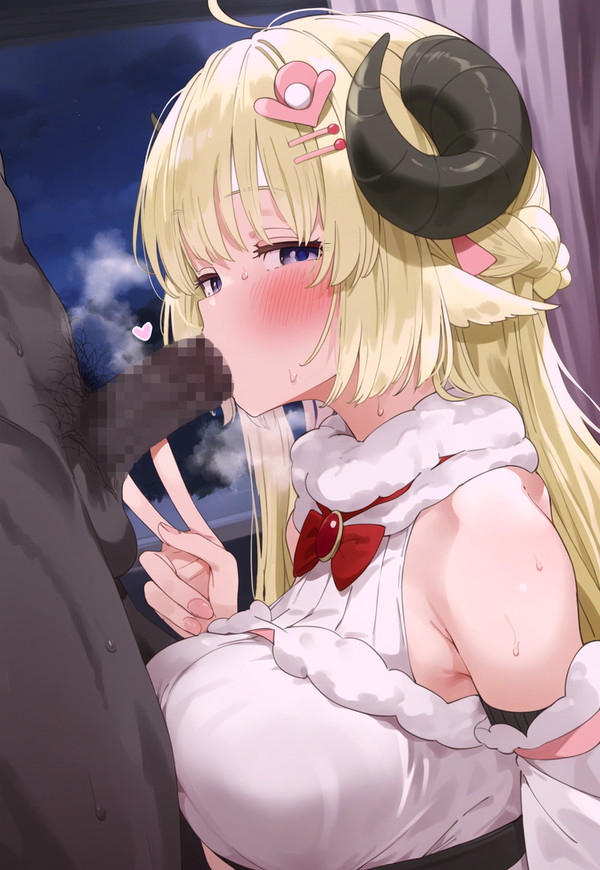

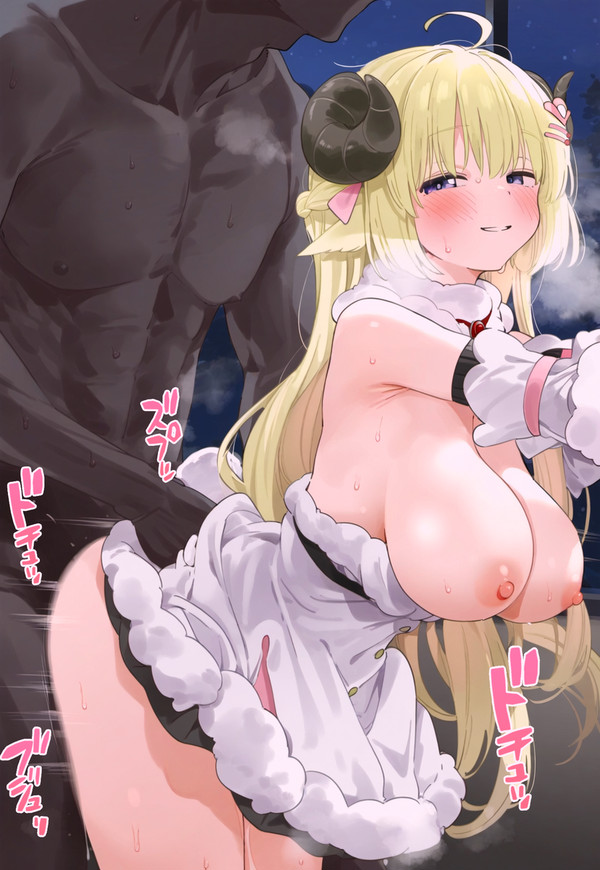

In [10]:
#画像を確認してみよう
import requests
from IPython.display import display, Image

# リファラーを設定して画像を表示
headers = {'Referer': 'https://www.pixiv.net'}

for url in df['imageUrlLarge']:
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        display(Image(response.content))
    else:
        print(f"Failed to retrieve {url}")

In [12]:
#ユーザー検索
df = search_users('しぐれ')
df

,id,name,account,profileImageUrlSquareMedium,profileImageUrlMedium,profileImageUrlLarge
0,431873,しぐれうい,ui_shig,None,https://i.pximg.net/user-profile/img/2016/01/0...,None
1,3360356,猫原しぐれ,shigure0730,None,https://i.pximg.net/user-profile/img/2021/05/0...,None
2,66875787,小夜しぐれ,user_uvsc5454,None,https://i.pximg.net/user-profile/img/2021/11/1...,None


In [13]:
#ハッシュタグ検索
df = search_hashtags('わため')
df

,name,translatedName
0,角巻わため,Watame Tsunomaki
1,わため,None
2,わためいと,None
3,つのまきわため,None
4,天音かなた/常闇トワ/角巻わため/百鬼あやめ/がうる・ぐら,None
5,一伊那尓栖/常闇トワ/天音かなた/角巻わため/百鬼あやめ,None
6,角巻わため新衣装,None
7,竈門禰豆子/紫咲シオン/角巻わため,None
8,ケツフックのわため,None
9,ギリギリ悪くないわため,None
